In [62]:
import os
import sys
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../../")
from src.filepath import ABSOLUTE_PATH
from src.train.heatpipe import load_data, renormalize
from src.model.transolver import Transolver
from src.model.GeoFNO import GeoFNO2d as FNO
from src.utils.utils import relative_error, to_np, plot_scatter_compare, find_max_min

In [63]:
device = "cuda"
model_type = "transformer"
batchsize = 2000 if model_type == "transformer" else 64

In [64]:
train_loader, test_loader = load_data(ABSOLUTE_PATH, batchsize, 14000, device=device, model_type=model_type)
del train_loader

In [65]:
if model_type == "transformer":
    model = Transolver(
        space_dim=2,
        n_layers=5,
        n_hidden=64,
        dropout=0.0,
        n_head=8,
        Time_Input=True,
        act="gelu",
        mlp_ratio=1,
        fun_dim=10,
        out_dim=3,
        slice_num=16,
        ref=8,
        unified_pos=False,
    ).to(device)
elif model_type == "FNO":
    modes = [8, 8, 8]
    model = FNO(
        modes1=modes[0],
        modes2=modes[1],
        modes3=modes[2],
        width=32,
        in_channels=10,
        out_channels=3,
    ).to(device)

model.load_state_dict(torch.load("../../results/heatpipe/surrogate/" + model_type + "/model.pt")["model"])

C:\Users\taozhan\AppData\Local\Temp\ipykernel_9984\2791339486.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../../results/heatpipe/s

<All keys matched successfully>

## VAL

In [66]:
mae_n_T = 0
mae_T = 0
rmae_T = 0
mae_n_s = 0
mae_s = 0
rmae_s = 0

loader = test_loader


with torch.no_grad():

    for batch in loader:
        if model_type in ["transformer", "FNO"]:
            coord, fx, y = batch
            data_pred_n = model((coord, fx))
            data_pred = renormalize(data_pred_n)
            data_true_n = y
            data_true = renormalize(y)
        elif model_type == "gnn":
            data_pred_n = model(batch).reshape(-1, 804, 3)
            data_pred = renormalize(data_pred_n)
            y, coord = batch.y.reshape(-1, 804, 3), batch.coord.reshape(-1, 804, 2)
            data_true_n = y
            data_true = renormalize(y)

        mae_n_T += torch.mean(torch.abs(data_true_n[..., 0:1] - data_pred_n[..., 0:1]))
        mae_T += torch.mean(torch.abs(data_true[..., 0:1] - data_pred[..., 0:1]))
        rmae_T += relative_error(data_true[..., 0:1], data_pred[..., 0:1])
        mae_n_s += torch.mean(torch.abs(data_true_n[..., 1:] - data_pred_n[..., 1:]))
        mae_s += torch.mean(torch.abs(data_true[..., 1:] - data_pred[..., 1:]))
        rmae_s += relative_error(data_true[..., 1:], data_pred[..., 1:])
mae_n_T, mae_T, rmae_T = mae_n_T / len(loader), mae_T / len(loader), rmae_T / len(loader)
mae_n_s, mae_s, rmae_s = mae_n_s / len(loader), mae_s / len(loader), rmae_s / len(loader)
mae_n_T, mae_T, rmae_T, mae_n_s, mae_s, rmae_s

(tensor(0.0023, device='cuda:0'),
 tensor(0.6408, device='cuda:0'),
 0.0007652016657014047,
 tensor(0.0037, device='cuda:0'),
 tensor(7.7647e-06, device='cuda:0'),
 0.0025233092807954356)

In [67]:
data_pred.shape, data_true.shape

(torch.Size([1984, 804, 3]), torch.Size([1984, 804, 3]))

In [68]:
coord.shape

torch.Size([1984, 804, 2])

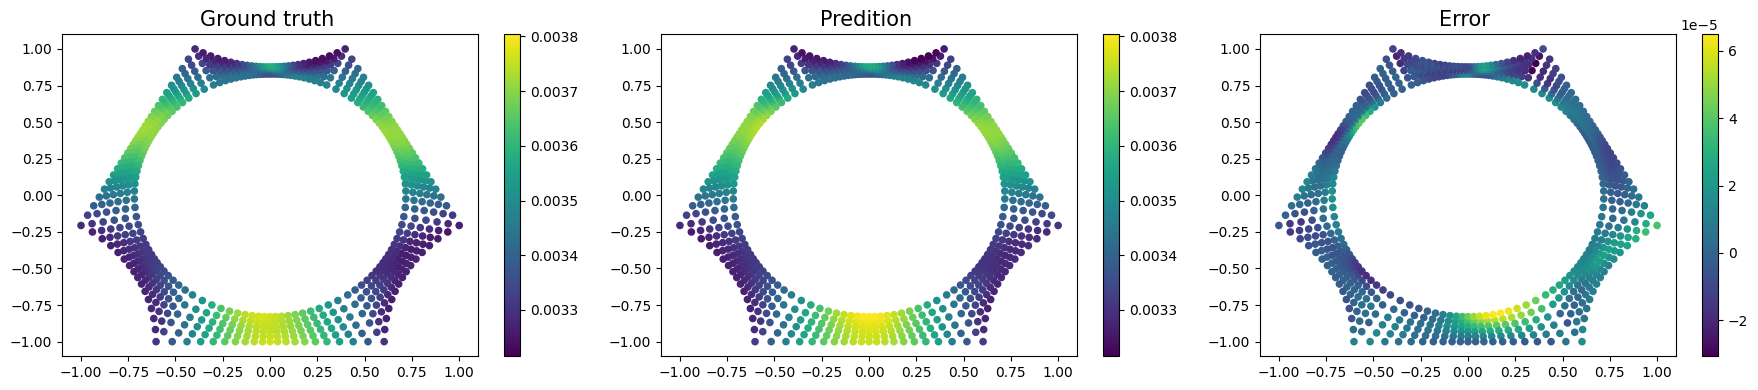

In [69]:
batch_n = np.random.randint(0, data_pred.shape[0])
phy_tag = np.random.randint(0, 3)
coord_x = to_np(coord[batch_n, :, 0])
coord_y = to_np(coord[batch_n, :, 1])
data_pred_np = to_np(data_pred[batch_n, :, phy_tag])
data_true_np = to_np(data_true[batch_n, :, phy_tag])
plot_scatter_compare(coord_x, coord_y, data_true_np, data_pred_np, figsize=(18, 4), pointsize=20)

val in 16 elements

In [70]:
# x = np.load("../../data/heatpipe/x.npy").reshape(-1, 16, 804, 10)
# y = np.load("../../data/heatpipe/y.npy").reshape(-1, 16, 804, 3)
# n_batch = 0  # np.random.randint(0, 1000)
# x = torch.tensor(x[n_batch]).to(device).float()
# data_true = torch.tensor(y[batch_n]).to(device).float()
x = torch.tensor(np.load("../../data/heatpipe/x.npy")[:16]).to(device).float()
y = torch.tensor(np.load("../../data/heatpipe/y.npy")[:16]).to(device).float()
data_true = to_np(renormalize(y))
if model_type == "FNO":
    coord = torch.zeros(x.shape[1], 3).to(device)
    coordxy = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coordxy[:, 0] = (coordxy[:, 0] - 0.0455) / (0.065345 - 0.0455)
    coordxy[:, 1] = (coordxy[:, 1] - 0.072) / (0.08918 - 0.072)
    coord[:, :-1] = coordxy
    coord = coord.expand(x.shape[0], -1, -1)
else:
    coord = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coord[:, 0] = (coord[:, 0] - 0.0455) / (0.065345 - 0.0455) * 2 - 1
    coord[:, 1] = (coord[:, 1] - 0.072) / (0.08918 - 0.072) * 2 - 1
    coord = coord.expand(x.shape[0], -1, -1)
y_p = to_np(renormalize(model((coord, x))))
coord.shape, data_true.shape, x.shape, data_true.shape, y_p.shape

(torch.Size([16, 804, 2]),
 (16, 804, 3),
 torch.Size([16, 804, 10]),
 (16, 804, 3),
 (16, 804, 3))

In [71]:
find_max_min(x), find_max_min(y), find_max_min(coord), find_max_min(y_p)

((1.0, -1.0),
 (0.8831485509872437, -1.0),
 (1.0000064373016357, -1.0),
 (1463.0211, 0.0029220043))

In [72]:
y_p = to_np(renormalize(model((coord, x))))
relative_error(data_true[..., 0], y_p[..., 0]), relative_error(data_true[..., 1:], y_p[..., 1:])

(0.000778782763518393, 0.002526430878788233)

In [73]:
bc1 = np.load("../../data/heatpipe/1/bc.npy")
bc2 = np.load("../../data/heatpipe/2/bc.npy")
bc = np.concatenate((bc1, bc2), axis=0)
x = np.load("../../data/heatpipe/x.npy").reshape(-1, 16, 804, 10)
y = np.load("../../data/heatpipe/y.npy").reshape(-1, 16, 804, 3)

batch_n = 903  # np.random.randint(0, 1000)
x = torch.tensor(x[batch_n]).to(device).float()
flux = x[:, -1, -1]
data_true = torch.tensor(y[batch_n]).to(device).float()
data_true = to_np(renormalize(data_true))
data_true.shape, x.shape, data_true.shape, bc[batch_n], batch_n

((16, 804, 3),
 torch.Size([16, 804, 10]),
 (16, 804, 3),
 array([[0, 1, 1],
        [0, 0, 0],
        [0, 1, 1]], dtype=int64),
 903)

## update function

In [74]:
def update(model, neighbors, multi_field, boundary_emb, cond_shape=10, other_condition=None):  # N,M,3
    # boundary in neighbors should corrspond with boundary
    device = multi_field.device
    n_element, n_node = multi_field.shape[0], multi_field.shape[1]
    channel = multi_field.shape[-1]
    node_feature = torch.zeros((n_element, n_node) + (cond_shape,)).to(device)
    coord = other_condition[0]
    flux = other_condition[1]
    for i in range(n_element):
        for j, neighbor in enumerate(neighbors[i + 1]):
            if not isinstance(neighbor, int):
                b_emb = torch.tensor(boundary_emb(neighbor)).to(device)
                node_feature[i, :, j * channel : j * channel + channel] = b_emb
            else:
                node_feature[i, :, j * channel : j * channel + channel] = multi_field[neighbor - 1]
        node_feature[i, :, -1:] = flux[i]
    update_field = model((coord, node_feature))
    return update_field

In [75]:
def boundary_emb_f(b_type, n_nods=804):
    free_emb = np.array([0, 0, 0])  # np.ones((1, 8)) * -1
    sym_emb = np.array([0, 1, 1])  # np.ones((1, 8)) * -2
    if b_type == "sym":
        return np.tile(sym_emb, (n_nods, 1))
    elif b_type == "free":
        return np.tile(free_emb, (n_nods, 1))

## test in training medium assembly

validation data

In [76]:
left = "free" if all(x == y for x, y in zip(bc[batch_n, 0], [0, 0, 0])) else "sym"
right = "free" if all(x == y for x, y in zip(bc[batch_n, 1], [0, 0, 0])) else "sym"
bottom = "free" if all(x == y for x, y in zip(bc[batch_n, 2], [0, 0, 0])) else "sym"
# left = "free"
# right = "free"
# bottom = (renomalize_disp(-0.0832), renomalize_disp(-0.2587))  # "fix"
neighbors = {
    1: (left, right, 11),
    2: (left, 11, 12),
    3: (11, right, 13),
    4: (left, 12, 14),
    5: (12, 13, 15),
    6: (13, right, 16),
    7: (left, 14, bottom),
    8: (14, 15, bottom),
    9: (15, 16, bottom),
    10: (16, right, bottom),
    11: (3, 2, 1),
    12: (5, 4, 2),
    13: (6, 5, 3),
    14: (8, 7, 4),
    15: (9, 8, 5),
    16: (10, 9, 6),
}
left, right, bottom

('sym', 'free', 'sym')

In [ ]:
iter_max = 1000
data_p = torch.zeros(size=(16, 804, 3)).to(device)
alpha = 0.5
import time

start = time.time()
with torch.no_grad():
    for i in range(iter_max):
        data_p_old = data_p
        data_p = (
            update(
                model,
                neighbors=neighbors,
                multi_field=data_p_old.clone(),
                boundary_emb=boundary_emb_f,
                other_condition=[coord, flux],
            )
            * (1 - alpha)
            + alpha * data_p_old
        )
        loss = relative_error(data_p, data_p_old)
        print("loss: ", loss)

        if loss < 1e-4:
            print("converse in iteration: ", i)
            break

        if i == iter_max - 1:
            print("up to max iteration")
end = time.time()
print("time: ", (end - start) / (i + 1))
data_pred = renormalize(to_np(data_p))
data_pred.shape

loss:  1.0
loss:  0.33660781383514404
loss:  0.14634019136428833
loss:  0.0685751736164093
loss:  0.03487293794751167
loss:  0.018843358382582664
loss:  0.011013980954885483
loss:  0.0071915872395038605
loss:  0.005300719290971756
loss:  0.004289885517209768
loss:  0.003668668679893017
loss:  0.00323020713403821
loss:  0.002890125848352909
loss:  0.002612002659589052
loss:  0.0023779082112014294
loss:  0.0021775132045149803
loss:  0.002004037145525217
loss:  0.0018526252824813128
loss:  0.0017196284607052803
loss:  0.0016022335039451718
loss:  0.0014982097782194614
loss:  0.0014057524967938662
loss:  0.0013233874924480915
loss:  0.0012498698197305202
loss:  0.0011841474333778024
loss:  0.001125312875956297
loss:  0.0010725798783823848
loss:  0.0010252746287733316
loss:  0.0009828112088143826
loss:  0.0009446878102608025
loss:  0.0009104894706979394
loss:  0.0008798453491181135
loss:  0.0008524628356099129
loss:  0.0008280743495561182
loss:  0.0008064535795710981
loss:  0.00078739807941

(16, 804, 3)

In [78]:
def coord_transform(coord):

    move_dis = 1 * np.array(
        [
            [0, 0],
            [-0.013856407, -0.024],
            [0.013856406, -0.024],
            [-0.027712807, -0.048],
            [0.0, -0.048],
            [0.027712813, -0.048],
            [-0.041569220, -0.072],
            [-0.013856407, -0.072],
            [0.013856406, -0.0720],
            [0.0415692190, -0.072],
            [0, 0],
            [-0.013856407, -0.024],
            [0.013856406, -0.024],
            [-0.027712807, -0.048],
            [0.0, -0.048],
            [0.027712813, -0.048],
        ]
    )

    sym = [-1] * 10 + [0.072, 0.072, 0.072, 0.072, 0.072, 0.072]

    def sym_block(y_coords, sym_axis):
        if sym_axis < 0:
            return y_coords
        else:
            sym_y_coords = 2 * sym_axis - y_coords
            return sym_y_coords

    coord_new = torch.zeros_like(coord)
    if model_type == "FNO":
        coord_new[:, :, 0] = (coord[:, :, 0]) * (0.065345 - 0.0455) + 0.0455
        coord_new[:, :, 1] = (coord[:, :, 1]) * (0.08918 - 0.072) + 0.072
    else:
        coord_new[:, :, 0] = (coord[:, :, 0] + 1) / 2 * (0.065345 - 0.0455) + 0.0455
        coord_new[:, :, 1] = (coord[:, :, 1] + 1) / 2 * (0.08918 - 0.072) + 0.072
    for i in range(move_dis.shape[0]):
        coord_new[i, :, 0] = coord_new[i, :, 0] + move_dis[i][0]
        coord_new[i, :, 1] = sym_block(coord_new[i, :, 1], sym[i])
        coord_new[i, :, 1] = coord_new[i, :, 1] + move_dis[i][1]
    # coord_new = to_np(coord_new.reshape(-1, 2))
    # coord_new_x = coord_new[:, 0]
    # coord_new_y = coord_new[:, 1]
    return coord_new

In [79]:
if model_type == "FNO":
    coord_new = coord_transform(coord[..., :2])
else:
    coord_new = coord_transform(coord)


coord_new = to_np(coord_new.reshape(-1, 2))


coord_new_x = coord_new[:, 0]


coord_new_y = coord_new[:, 1]

In [80]:
relative_error(data_true[..., :1], data_pred[..., :1]), relative_error(data_true[..., 1:], data_pred[..., 1:])

(0.005616099573671818, 0.01417677290737629)

In [20]:
relative_error(data_true.reshape(-1, 3)[..., :1], data_pred.reshape(-1, 3)[..., :1]), relative_error(
    data_true[..., 1:].reshape(-1, 3), data_pred[..., 1:].reshape(-1, 3)
)

(0.0031245015746918484, 0.011322594400662096)

In [21]:
find_max_min(data_true[..., 0]), find_max_min(data_true[..., 1]), find_max_min(data_pred[..., 0]), find_max_min(
    data_pred[..., 1]
)

((1369.614, 948.0),
 (0.0058404957, 0.0030519299),
 (1378.3357, 944.56836),
 (0.0059049525, 0.0030279446))

### T

In [22]:
coord_new_x.shape, data_true.shape

((12864,), (16, 804, 3))

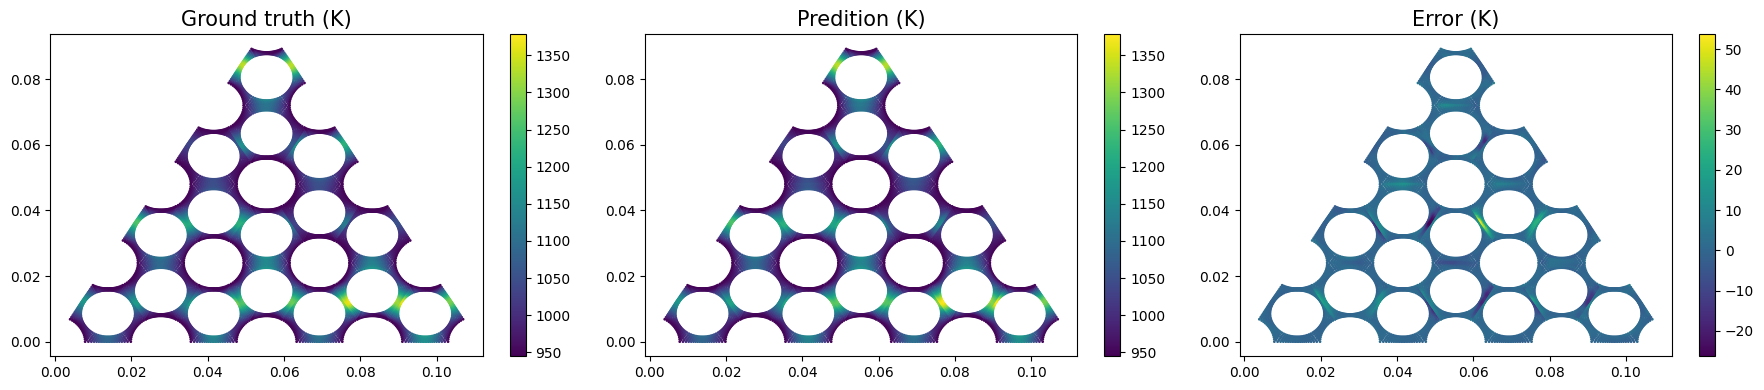

In [23]:
plot_scatter_compare(
    coord_new_x,
    coord_new_y,
    to_np(data_true)[..., 0].reshape(-1),
    to_np(data_pred)[..., 0].reshape(-1),
    figsize=(18, 4),
    pointsize=1,
    fontsize=15,
    Unit_="K",
    savep=ABSOLUTE_PATH + "/results/heatpipe/surrogate/T.pdf",
)

### disp_x

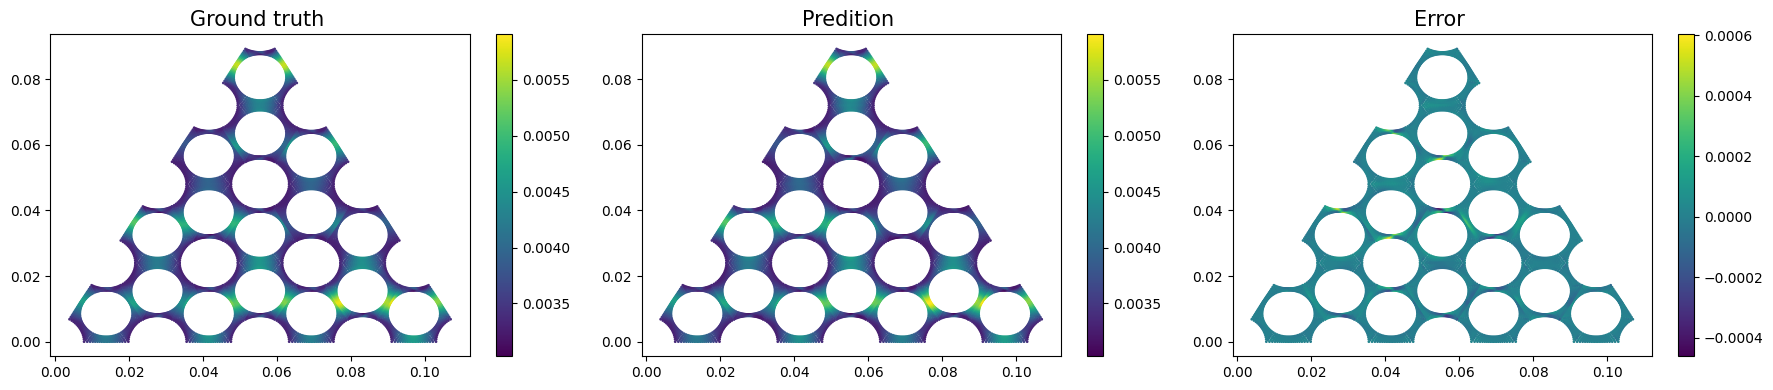

In [24]:
plot_scatter_compare(
    coord_new_x,
    coord_new_y,
    to_np(data_true)[..., 1].reshape(-1),
    to_np(data_pred)[..., 1].reshape(-1),
    figsize=(18, 4),
    pointsize=1,
    fontsize=15,
    # Unit_="K",
    savep=ABSOLUTE_PATH + "/results/heatpipe/surrogate/strainx.pdf",
)

### disp_y

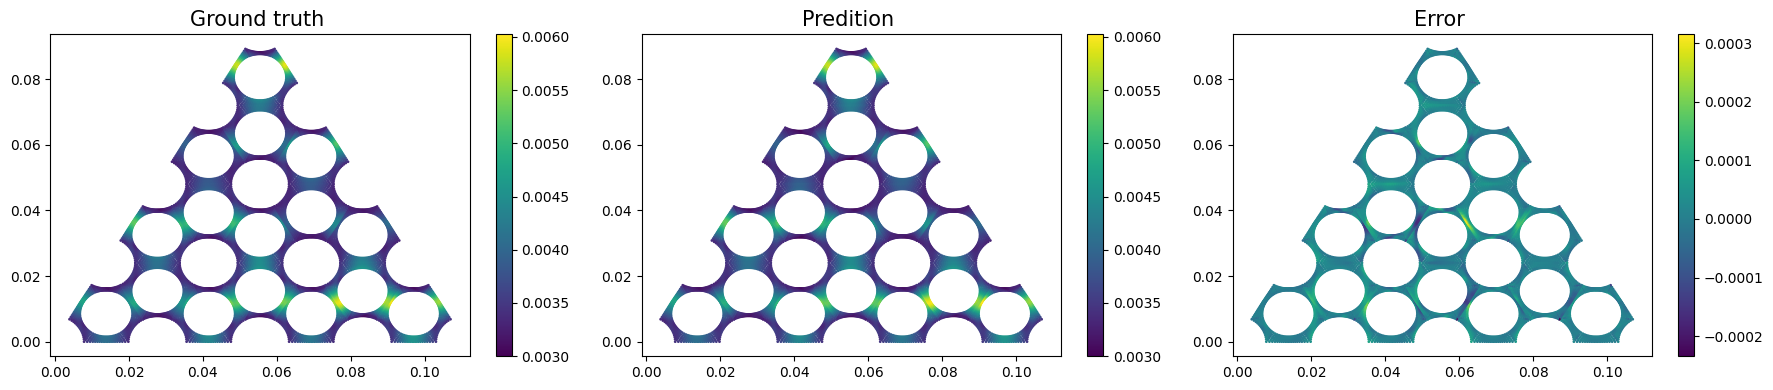

In [25]:
plot_scatter_compare(
    coord_new_x,
    coord_new_y,
    to_np(data_true)[..., 2].reshape(-1),
    to_np(data_pred)[..., 2].reshape(-1),
    figsize=(18, 4),
    pointsize=1,
    fontsize=15,
    # Unit_="K",
    savep=ABSOLUTE_PATH + "/results/heatpipe/surrogate/strainy.pdf",
)

## val in large structure

In [81]:
left = "sym"
right = "free"
bottom = "sym"
# left = "free"
# right = "free"
# bottom = (renomalize_disp(-0.0832), renomalize_disp(-0.2587))  # "fix"
neighbors = {
    # 1
    1: (left, right, 11),
    2: (left, 11, 12),
    3: (11, right, 13),
    4: (left, 12, 14),
    5: (12, 13, 15),
    6: (13, right, 16),
    7: (left, 14, 26),
    8: (14, 15, 25),
    9: (15, 16, 24),
    10: (16, right, 23),
    11: (3, 2, 1),
    12: (5, 4, 2),
    13: (6, 5, 3),
    14: (8, 7, 4),
    15: (9, 8, 5),
    16: (10, 9, 6),
    17: (55, 42, 27),
    18: (52, 27, 28),
    19: (27, 38, 29),
    20: (50, 28, 30),
    21: (28, 29, 31),
    22: (29, 35, 32),
    23: (49, 30, 10),
    24: (30, 31, 9),
    25: (31, 32, 8),
    26: (32, 33, 7),
    27: (19, 18, 17),
    28: (21, 20, 18),
    29: (22, 21, 19),
    30: (24, 23, 20),
    31: (25, 24, 21),
    32: (26, 25, 22),
    33: (left, 26, 43),
    34: (left, 43, 44),
    35: (43, 22, 45),
    36: (left, 44, 46),
    37: (44, 45, 47),
    38: (45, 19, 48),
    39: (left, 46, bottom),
    40: (46, 47, bottom),
    41: (47, 48, bottom),
    42: (48, 17, bottom),
    43: (35, 34, 33),
    44: (37, 36, 34),
    45: (38, 37, 35),
    46: (40, 39, 36),
    47: (41, 40, 37),
    48: (42, 41, 38),
    49: (23, right, 59),
    50: (20, 59, 60),
    51: (59, right, 61),
    52: (18, 60, 62),
    53: (60, 61, 63),
    54: (61, right, 64),
    55: (17, 62, bottom),
    56: (62, 63, bottom),
    57: (63, 64, bottom),
    58: (64, right, bottom),
    59: (51, 50, 49),
    60: (53, 52, 50),
    61: (54, 53, 51),
    62: (56, 55, 52),
    63: (57, 56, 53),
    64: (58, 57, 54),
}

In [82]:
if model_type == "FNO":
    coord = torch.zeros(804, 3).to(device)
    coordxy = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coordxy[:, 0] = (coordxy[:, 0] - 0.0455) / (0.065345 - 0.0455)
    coordxy[:, 1] = (coordxy[:, 1] - 0.072) / (0.08918 - 0.072)
    coord[:, :-1] = coordxy
    coord = coord.expand(64, -1, -1)
else:
    coord = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
    coord[:, 0] = (coord[:, 0] - 0.0455) / (0.065345 - 0.0455) * 2 - 1
    coord[:, 1] = (coord[:, 1] - 0.072) / (0.08918 - 0.072) * 2 - 1
    coord = coord.expand(64, -1, -1)
flux = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/val_flux.npy")).to(device)
flux = (flux - 1e5) / 9e5 * 2 - 1
coord.shape, flux.shape

(torch.Size([64, 804, 2]), torch.Size([64]))

In [85]:
iter_max = 1000
data_p = torch.zeros(size=(64, 804, 3)).to(device)
alpha = 0.5
start = time.time()
with torch.no_grad():
    for i in range(iter_max):
        data_p_old = data_p
        data_p = (
            update(
                model,
                neighbors=neighbors,
                multi_field=data_p_old.clone(),
                boundary_emb=boundary_emb_f,
                other_condition=[coord, flux],
            )
            * (1 - alpha)
            + alpha * data_p_old
        )
        loss = relative_error(data_p, data_p_old)
        print("loss: ", loss)

        if loss < 1e-4:
            print("converse in iteration: ", i)
            break

        if i == iter_max - 1:
            print("up to max iteration")
data_pred = renormalize(to_np(data_p))
end = time.time()
print("time: ", (end - start) / (i + 1))
data_pred.shape

loss:  1.0
loss:  0.33779507875442505
loss:  0.14566199481487274
loss:  0.06887103617191315
loss:  0.03530671447515488
loss:  0.01928624138236046
loss:  0.011486857198178768
loss:  0.007725696079432964
loss:  0.0058945403434336185
loss:  0.004917984828352928
loss:  0.004303514491766691
loss:  0.0038511953316628933
loss:  0.0034837587736546993
loss:  0.003170167561620474
loss:  0.0028964136727154255
loss:  0.002655093092471361
loss:  0.002441628836095333
loss:  0.002252823207527399
loss:  0.0020862335804849863
loss:  0.0019398616859689355
loss:  0.0018119816668331623
loss:  0.0017010415904223919
loss:  0.0016055989544838667
loss:  0.0015242784284055233
loss:  0.0014557442627847195
loss:  0.0013987041311338544
loss:  0.0013519036583602428
loss:  0.0013141424860805273
loss:  0.00128429033793509
loss:  0.0012612873688340187
loss:  0.001244166400283575
loss:  0.0012320536188781261
loss:  0.0012241810327395797
loss:  0.0012198754120618105
loss:  0.001218553981743753
loss:  0.0012197055621072

(64, 804, 3)

In [13]:
def coord_transform2(coord):
    base_coord = coord

    coord1 = np.zeros_like(base_coord)
    coord1[..., 0] = 2 * 0.0554256215 - base_coord[..., 0]
    coord1[..., 1] = -base_coord[..., 1]

    coord2 = np.zeros_like(base_coord)
    coord2[..., 0] = base_coord[..., 0] - 0.055425618
    coord2[..., 1] = base_coord[..., 1] - 0.096

    coord3 = np.zeros_like(base_coord)
    coord3[..., 0] = base_coord[..., 0] + 0.055425618
    coord3[..., 1] = base_coord[..., 1] - 0.096
    return np.concatenate((base_coord, coord1, coord2, coord3), axis=0)

In [14]:
coord = torch.tensor(np.load(ABSOLUTE_PATH + "/data/heatpipe/coord.npy")).to(device).float()
coord[:, 0] = (coord[:, 0] - 0.0455) / (0.065345 - 0.0455) * 2 - 1
coord[:, 1] = (coord[:, 1] - 0.072) / (0.08918 - 0.072) * 2 - 1
coord = coord.expand(16, -1, -1)
coord = to_np(coord_transform(coord))
coord.shape

(16, 804, 2)

In [15]:
coord_val = np.load(ABSOLUTE_PATH + "/data/heatpipe/coord_val.npy")
val_y = np.load(ABSOLUTE_PATH + "/data/heatpipe/val_y.npy")
bound = [[948, 1500], [-4e-4, 1.2e-3], [-4e-4, 1.2e-3]]
val_y = renormalize(val_y)
# for i in range(3):
#     val_y[..., i] = (val_y[..., i] - bound[i][0]) / (bound[i][1] - bound[i][0])

In [16]:
tolerance = 5e-5
coord_struture_big = coord_transform2(to_np(coord))
x_new, y_new = coord_struture_big[..., 0].reshape(-1), coord_struture_big[..., 1].reshape(-1)
val_y_sorted = np.empty_like(val_y)
for i, (x_val, y_val) in enumerate(zip(x_new, y_new)):
    distances = np.sqrt((coord_val[:, 0] - x_val) ** 2 + (coord_val[:, 1] - y_val) ** 2)
    min_distance_index = np.argmin(distances)
    val_y_sorted[i] = val_y[min_distance_index]
    if distances[min_distance_index] > tolerance:
        print(
            f"Multiple matching coordinates found for ({i},{x_val}, {y_val}) within tolerance, the min distance is {distances[min_distance_index]}."
        )

In [17]:
mult_e = data_pred.reshape(-1, 3)

In [18]:
relative_error(mult_e[..., :1], val_y_sorted[..., :1]), relative_error(mult_e[..., 1:], val_y_sorted[..., 1:])

(0.011154924475954231, 0.028435788114009215)

In [20]:
def plot_scatter_compare(
    coord_x,
    coord_y,
    true_d,
    pred_d,
    pointsize=1,
    figsize=(18, 4),
    savep=None,
    fontsize=15,
    cmap="viridis",
    paraname="",
    Unit_="",
    language="eng",
    e_min=None,
    e_max=None,
):
    # compare
    # shape: w*h
    if torch.is_tensor(true_d):
        if true_d.is_cuda:
            true_d = true_d.cpu()
            pred_d = pred_d.cpu()
        true_d = true_d.numpy()
        pred_d = pred_d.numpy()
    title_list = ["Ground truth ", "Predition ", "Error "]

    vmin = min(np.min(true_d), np.min(pred_d))
    vmax = max(np.max(true_d), np.max(pred_d))

    Unit1 = ""
    if len(Unit_) > 0:
        Unit1 = "(" + Unit_ + ")"
    plt.figure(figsize=figsize)
    plt.subplot(311)
    sc1 = plt.scatter(coord_x, coord_y, c=true_d, cmap=cmap, edgecolors=None, s=pointsize, vmin=vmin, vmax=vmax)
    plt.title(title_list[0] + paraname + Unit1, fontsize=fontsize)
    plt.colorbar(sc1)

    plt.subplot(312)
    sc2 = plt.scatter(coord_x, coord_y, c=pred_d, cmap=cmap, edgecolors=None, s=pointsize, vmin=vmin, vmax=vmax)
    plt.title(title_list[1] + paraname + Unit1, fontsize=fontsize)
    plt.colorbar(sc2)

    plt.subplot(313)
    if e_max is None or e_min is None:
        e_max, e_min = find_max_min(pred_d - true_d)
    sc3 = plt.scatter(
        coord_x, coord_y, c=(pred_d - true_d), cmap=cmap, edgecolors=None, s=pointsize, vmin=e_min, vmax=e_max
    )
    plt.title(title_list[2] + paraname + Unit1, fontsize=fontsize)
    plt.colorbar(sc3)

    plt.tight_layout()
    if savep is not None:
        plt.savefig(savep)
    plt.show()

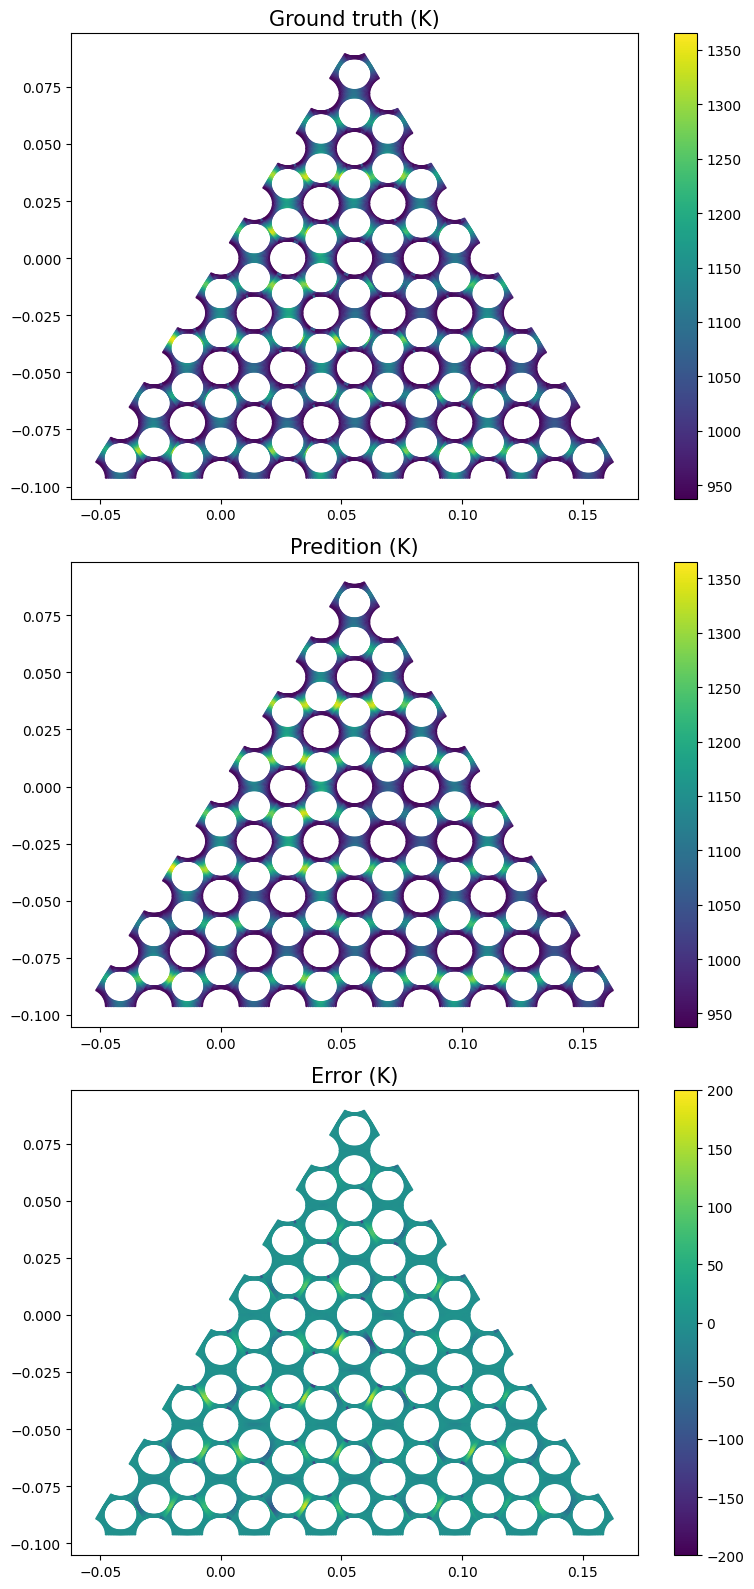

In [21]:
plot_scatter_compare(
    x_new,
    y_new,
    to_np(mult_e)[:, 0],
    to_np(val_y_sorted)[:, 0],
    figsize=(8, 16),
    pointsize=1,
    fontsize=15,
    Unit_="K",
    # paraname="T",
    savep=ABSOLUTE_PATH + "/results/heatpipe/surrogate/s_val_T.png",
    e_max=200,
    e_min=-200,
)

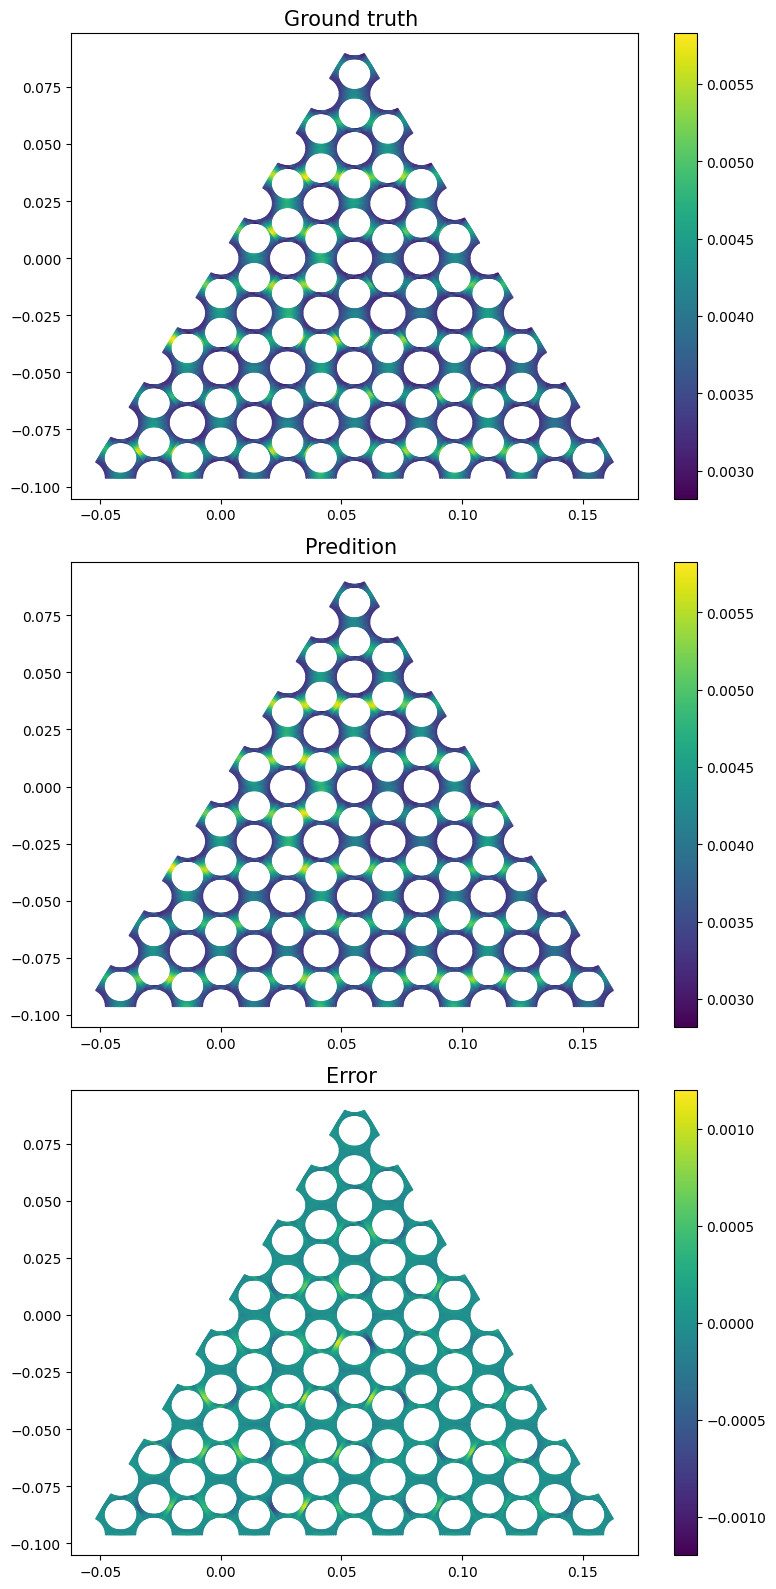

In [22]:
plot_scatter_compare(
    x_new,
    y_new,
    to_np(mult_e)[:, 1],
    to_np(val_y_sorted)[:, 1],
    figsize=(8, 16),
    pointsize=1,
    fontsize=15,
    # Unit_="K",
    savep=ABSOLUTE_PATH + "/results/heatpipe/surrogate/s_val_sx.png",
    e_max=1.2e-3,
    e_min=-1.2e-3,
)

In [ ]:
plot_scatter_compare(
    x_new,
    y_new,
    to_np(mult_e)[:, 2],
    to_np(val_y_sorted)[:, 2],
    figsize=(18, 4),
    pointsize=1,
    fontsize=15,
    savep=ABSOLUTE_PATH + "/results/heatpipe/surrogate/s_val_sy.png",
    e_max=1.2e-3,
    e_min=-1.2e-3,
)